In [ ]:
#importando biblioteca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py 
import scipy as sp
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tratamento dos dados

In [ ]:
#lendo os dados
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_excel("/content/drive/My Drive/Faculdade/Faculdade/Periodos/9º periodo/Ast/MICRODADOS.xlsx")

Mounted at /content/drive


In [ ]:
#filtrando os dados por Recife
dados_recife = data[data["MUNICIPIO"] ==  "RECIFE"]
dados_recife.shape

(2404, 4)

In [ ]:
x = dados_recife[np.logical_and(dados_recife['Data'] <= "2020-05-30", dados_recife['Data'] >= "2020-04-16")]
x2 = x.loc[:, ['Data', 'Total']]
x2 = x2.set_index('Data')


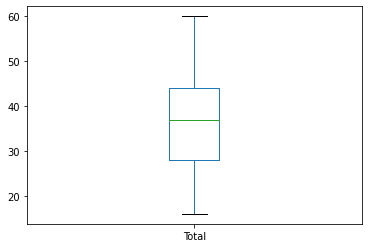

In [ ]:
boxplot = x2.boxplot(column=['Total'], grid=False)

In [ ]:
x2.describe()

,Total
count,45.000000
mean,36.844444
std,10.117392
min,16.000000
25%,28.000000
50%,37.000000
75%,44.000000
max,60.000000


In [ ]:
x1.describe()

,Total
count,45.000000
mean,89.311111
std,16.289738
min,50.000000
25%,82.000000
50%,92.000000
75%,101.000000
max,125.000000


O teste de hipótese será focado se a média de crimes contra o patrimônio  no período de quarentena rígida em comparação com o mesmo periódo do ano em relação aos outros anos alterou.

Assim:

**H0**: média(x2) - média(x1) = 0

**H1**: média(x2) - média(x1) != 0



In [ ]:
#criando x2 e x1
#x2 periodo entre o inicio e o fim da quarentena no ano de 2020
#x1 periodo entre o inicio e o fim da quarentena no ano de 2019

x2 = dados_recife[np.logical_and(dados_recife['Data'] <= "2020-05-30", dados_recife['Data'] >= "2020-04-16")]
x1 = dados_recife[np.logical_and(dados_recife['Data'] <= "2019-05-30", dados_recife['Data'] >= "2019-04-16")]

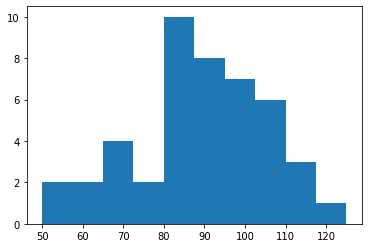

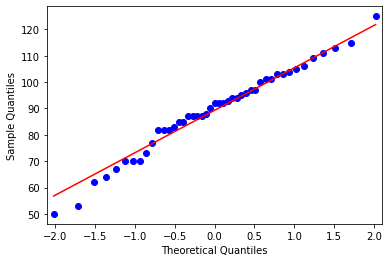

In [ ]:
#testando a normalidade (histograma e qqplot) de x1
plt.hist(x1["Total"])
sm.qqplot(x1["Total"], line="s")
plt.show()
#Aparentemente o x1 segue uma distruibuição normal, com alguns outliers

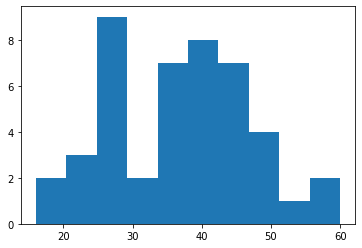

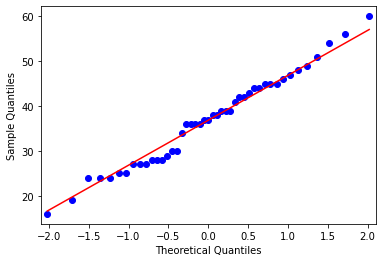

In [ ]:
#testando a normalidade (histograma e qqplot) de x2
plt.hist(x2["Total"])
sm.qqplot(x2["Total"], line="s")
plt.show()
#Aparentemente o x2 segue uma distruibuição normal, com alguns outliers

In [ ]:
#teste levene para testar se as variâncias são iguais
sp.stats.levene(x1['Total'], x2['Total'], center = 'mean')
#p-value abaixo de 0.05, então podemos rejeitar a hipótese nula de que as variâncias são iguais, logo podems afirmar com 95% de certeza que as variâncias 
#diferem

LeveneResult(statistic=7.3032359007749275, pvalue=0.00832699979184633)

In [ ]:
#teste-t para duas amostras independentes 

sp.stats.ttest_ind(x2['Total'], x1['Total'], equal_var=False)


Ttest_indResult(statistic=-17.72958702225097, pvalue=1.939199328786754e-27)

Portanto como é possível ver com o teste t, nossas médias das amostras diferem no mesmo periodo, de uma quarentena rígida em Recife.

Text(0, 0.5, 'Crimes contra patrimônio')

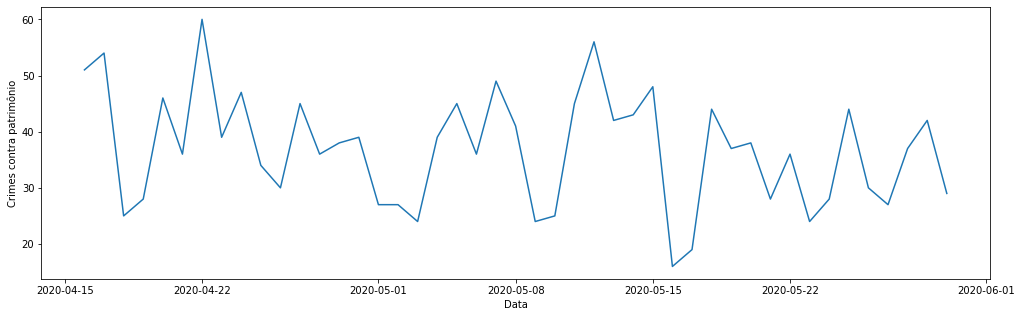

In [ ]:
#visualização gráfica
plt.figure(figsize=(17,5))
plt.plot(x2['Data'], x2['Total'])
plt.xlabel("Data")
plt.ylabel("Crimes contra patrimônio")
#Épossível ver que nossos dados aparentemente não tem tendência, porém tem uma sazonalidade aditiva

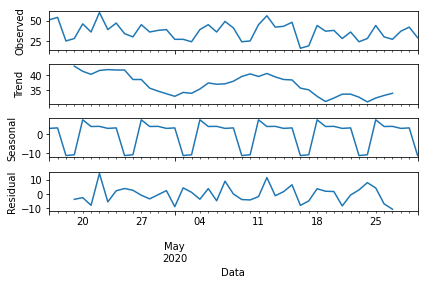

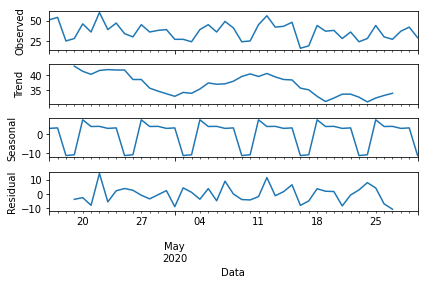

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(x2, model='additive')
result.plot()
#Como é visto, não tendência clara nos dados

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   45
Model:             ExponentialSmoothing   SSE                           2895.676
Optimized:                         True   AIC                            209.394
Trend:                   Multiplicative   BIC                            229.267
Seasonal:                      Additive   AICC                           221.136
Seasonal Periods:                     7   Date:                 Thu, 26 Nov 2020
Box-Cox:                          False   Time:                         14:27:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0522360                alpha                 True
smoothing_slope          

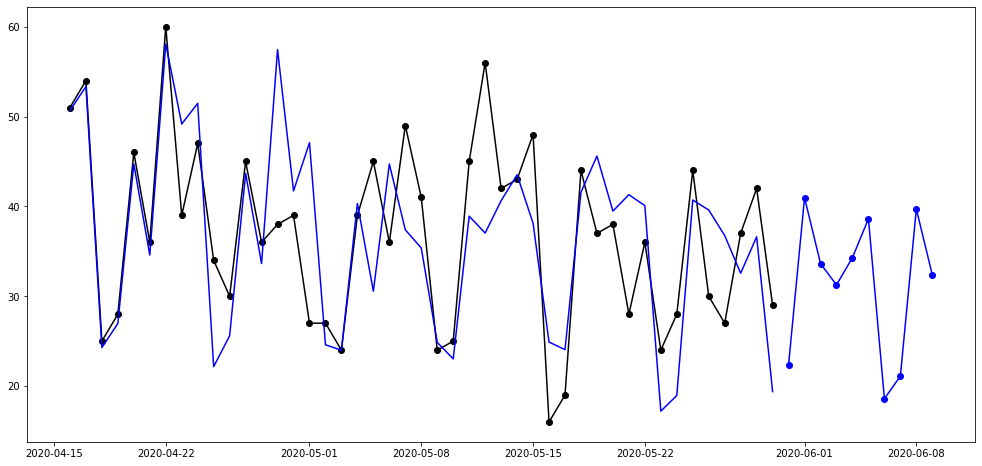

In [ ]:
#Método de holt-winters
#Nós temos uma série temporal sem tendência, mas com uma sazonalidade aditiva, então definimos o periodo sazonal como 7 que é a duração de uma semana
#pegaremos os pmelhores parâmetros dos métodos anteriores para testar

hot_w1 = HWES(x2, seasonal_periods=7, trend='mul', seasonal='add', damped=False)
fitted = hot_w1.fit()
fcast = fitted.forecast(10)

plt.figure(figsize=(17, 8))
plt.plot(x2, marker='o', color='black')
plt.plot(fitted.fittedvalues, color='blue')
line1, = plt.plot(fcast, marker='o', color='blue')

print(fitted.summary())


In [ ]:
fcast

2020-05-31    22.374817
2020-06-01    40.972324
2020-06-02    33.639037
2020-06-03    31.258856
2020-06-04    34.302276
2020-06-05    38.613848
2020-06-06    18.602042
2020-06-07    21.098045
2020-06-08    39.703510
2020-06-09    32.378132
Freq: D, dtype: float64

In [ ]:
x3 = dados_recife[np.logical_and(dados_recife['Data'] <= "2020-06-9", dados_recife['Data'] >= "2020-05-31")]
x3 = x3.loc[:, ['Data', 'Total']]
x3 = x3.set_index('Data')

In [ ]:
#RMSE
rmse = sqrt(mean_squared_error(x3, fcast))
rmse

9.143200052379848

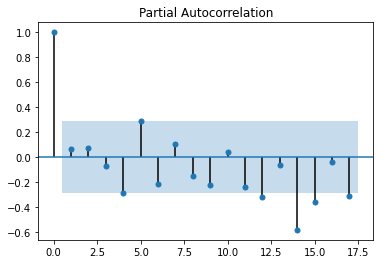

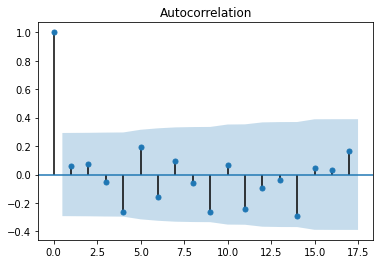

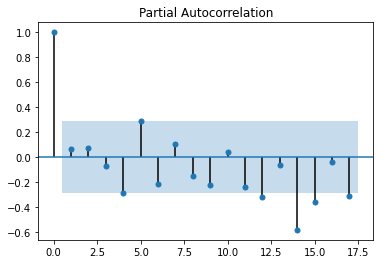

In [ ]:
#análise de resíduos
fitted.resid #resíduos do modelo
plot_acf(fitted.resid)
plot_pacf(fitted.resid)

In [ ]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(fitted.resid)
print ('lag       p-value     lb_stat   rejectH0')
reject = [] 
for i in range(len(ljung_box)):
  if p_value[i] > 0.05:
    print ("%-2d  %10.2f  %10.2f      %s" % (i+1, p_value[i], ljung_box[i], str("False")))
  else:
    print ("%-2d  %10.2f  %10.2f      %s" % (i+1, p_value[i], ljung_box[i], str("True")))


lag       p-value     lb_stat   rejectH0
1         0.66        0.19      False
2         0.80        0.45      False
3         0.89        0.61      False
4         0.39        4.10      False
5         0.29        6.12      False
6         0.28        7.48      False
7         0.33        7.99      False
8         0.42        8.17      False
9         0.20       12.19      False
10        0.25       12.48      False
11        0.14       16.09      False
12        0.16       16.70      False
13        0.21       16.81      False
14        0.07       22.64      False
15        0.09       22.79      False
16        0.12       22.86      False
17        0.09       24.99      False
18        0.09       26.29      False
19        0.11       26.69      False
20        0.07       30.21      False


In [ ]:
shapiro_test = shapiro(fitted.resid)
print(shapiro_test)

(0.969937264919281, 0.28807610273361206)


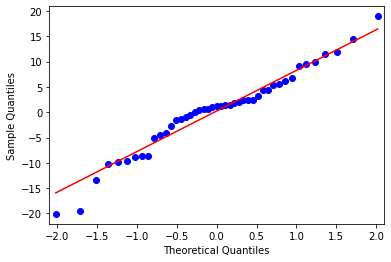

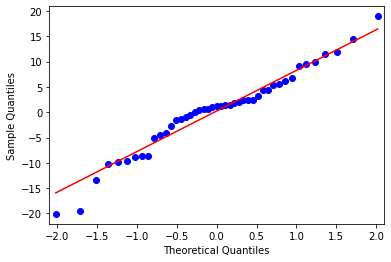

In [ ]:
sm.qqplot(fitted.resid, line="s")

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   45
Model:                     ARMA(3, 1)   Log Likelihood                -165.843
Method:                       css-mle   S.D. of innovations              9.631
Date:                Thu, 26 Nov 2020   AIC                            343.686
Time:                        15:10:03   BIC                            354.526
Sample:                    04-16-2020   HQIC                           347.727
                         - 05-30-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.7230      1.273     28.859      0.000      34.229      39.217
ar.L1.Total     0.5986      0.696      0.860      0.395      -0.765       1.963
ar.L2.Total    -0.2884      0.214     -1.347    

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Modelo autoregressivo de média móvel')

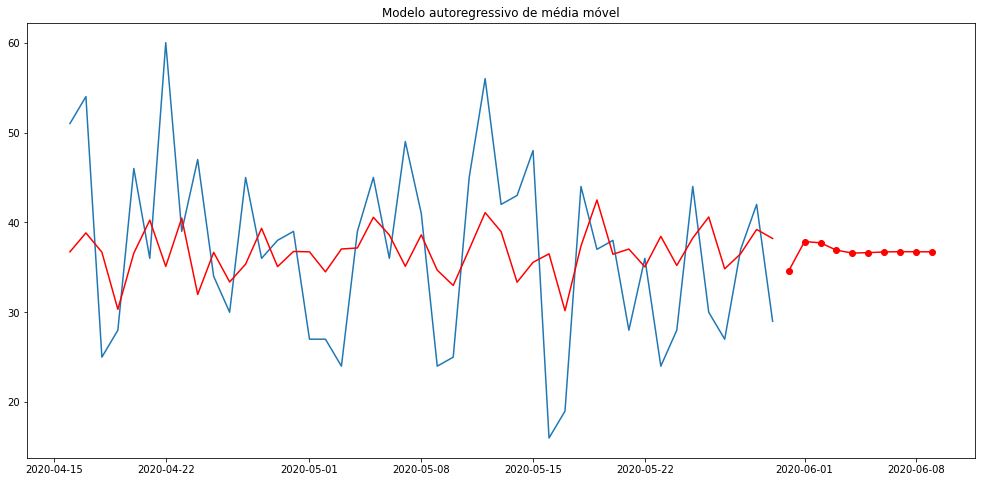

In [ ]:
model = ARIMA(x2, order=(3,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
forecast = model_fit.predict(start='2020-05-31', end='2020-06-09')
plt.figure(figsize=(17, 8))
plt.plot(x2)
plt.plot(model_fit.fittedvalues, color = 'red')
line1, = plt.plot(forecast, marker='o', color='red')
plt.title("Modelo autoregressivo de média móvel")

In [ ]:
arma_t = ArmaProcess(model_fit.arparams, model_fit.maparams)
print(arma_t.isinvertible)
print(arma_t.isstationary)

True
True


In [ ]:
forecast

2020-05-31    34.568018
2020-06-01    37.871975
2020-06-02    37.722647
2020-06-03    36.903634
2020-06-04    36.588909
2020-06-05    36.630732
2020-06-06    36.713698
2020-06-07    36.738680
2020-06-08    36.731384
2020-06-09    36.723138
Freq: D, dtype: float64

In [ ]:
rmse = sqrt(mean_squared_error(x3, forecast))
rmse

6.760262449778857

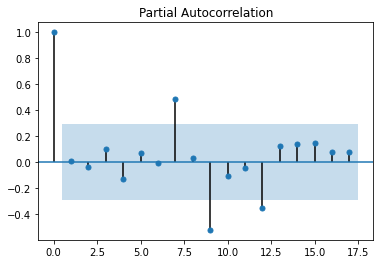

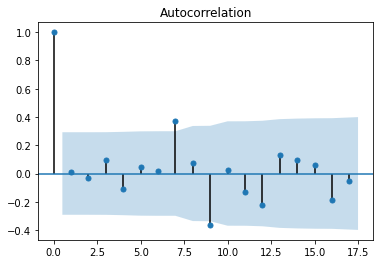

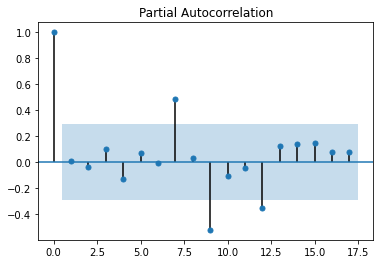

In [ ]:
model_fit.resid #resíduos do modelo
plot_acf(model_fit.resid)
plot_pacf(model_fit.resid)

In [ ]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(model_fit.resid)
print ('lag       p-value     lb_stat   rejectH0')
reject = [] 
for i in range(len(ljung_box)):
  if p_value[i] > 0.05:
    print ("%-2d  %10.2f  %10.2f      %s" % (i+1, p_value[i], ljung_box[i], str("False")))
  else:
    print ("%-2d  %10.2f  %10.2f      %s" % (i+1, p_value[i], ljung_box[i], str("True")))

lag       p-value     lb_stat   rejectH0
1         0.94        0.01      False
2         0.97        0.06      False
3         0.92        0.49      False
4         0.89        1.12      False
5         0.94        1.24      False
6         0.97        1.26      False
7         0.25        8.98      False
8         0.32        9.27      False
9         0.05       17.00      True
10        0.07       17.04      False
11        0.08       18.07      False
12        0.05       21.32      True
13        0.05       22.47      True
14        0.06       23.12      False
15        0.08       23.37      False
16        0.05       25.95      False
17        0.07       26.15      False
18        0.08       26.99      False
19        0.08       28.19      False
20        0.06       30.62      False


(0.9801126718521118, 0.6242665648460388)


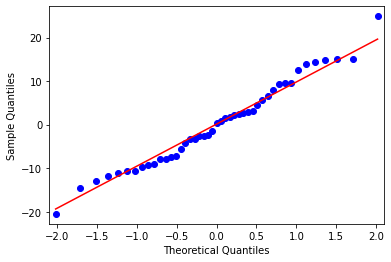

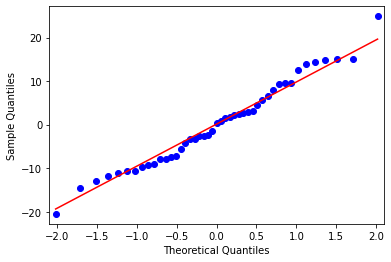

In [ ]:
shapiro_test = shapiro(model_fit.resid)
print(shapiro_test)
sm.qqplot(model_fit.resid, line="s")

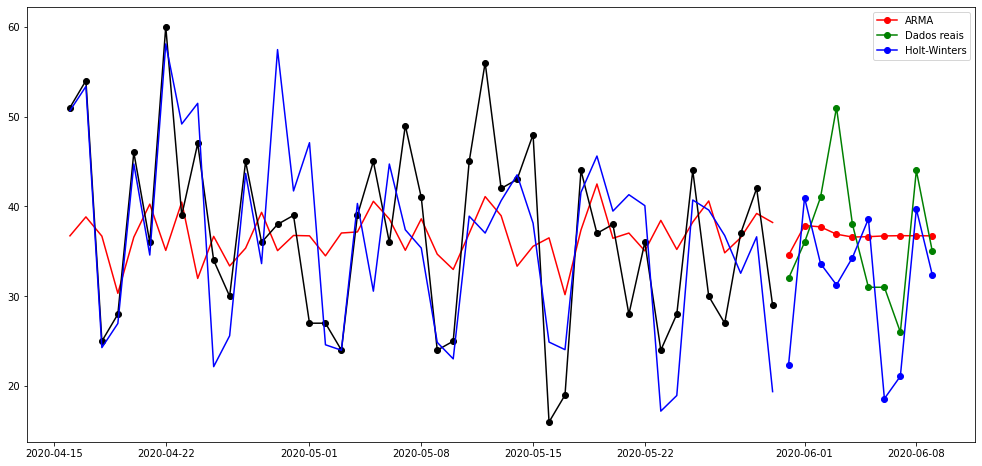

In [ ]:
plt.figure(figsize=(17, 8))

plt.plot(model_fit.fittedvalues, color = 'red')
line1, = plt.plot(forecast, marker='o', color='red')
plt.plot(x2, marker='o', color='black')
line2, = plt.plot(x3, marker='o', color='green')
plt.plot(fitted.fittedvalues, color='blue')
line3, = plt.plot(fcast, marker='o', color='blue')
plt.legend([line1, line2, line3], ['ARMA', 'Dados reais', 'Holt-Winters'])

In [ ]:
x3.describe()


,Total
count,10.000000
mean,36.500000
std,7.321961
min,26.000000
25%,31.250000
50%,35.500000
75%,40.250000
max,51.000000


In [ ]:
forecast.describe()

count    10.000000
mean     36.719281
std       0.883351
min      34.568018
25%      36.651474
50%      36.727261
75%      36.862395
max      37.871975
dtype: float64

In [ ]:
fcast.describe()

count    10.000000
mean     31.294289
std       8.015891
min      18.602042
25%      24.595827
50%      33.008584
75%      37.535955
max      40.972324
dtype: float64